# Reference:
https://pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/

In [154]:
import numpy as np
import cv2
import imutils

from imutils.perspective import four_point_transform
from imutils import contours
from matplotlib import pyplot as plt

In [155]:
# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

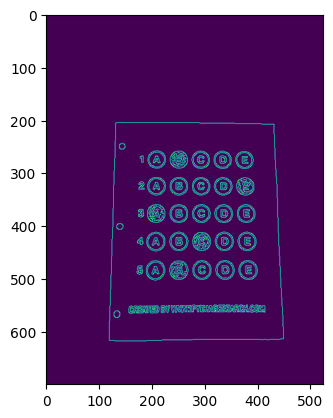

In [156]:
image = cv2.imread('../resources/bubble_choice_sample1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)

lower = 0.66 * np.mean(blur)
upper = 1.33 * np.mean(blur)
edged = cv2.Canny(blur, lower, upper)

plt.imshow(edged)

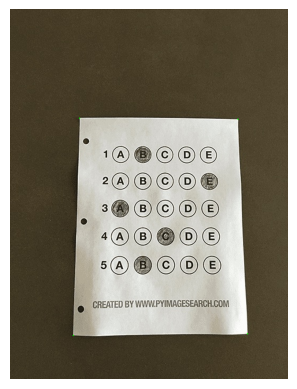

In [157]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

doc_cnt = None
if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if len(approx) == 4:
            doc_cnt = approx
            break
        
if doc_cnt is None:
    print('Cannot detect the answer sheet')
else:
    img = image.copy()
    cv2.drawContours(img, doc_cnt, -1, (0,255,0), 2)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

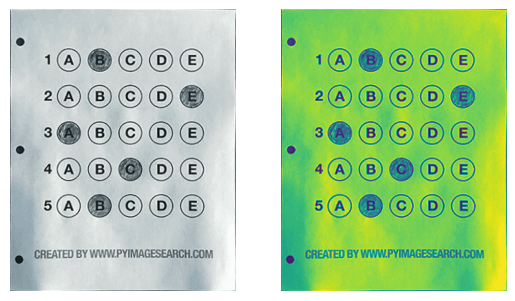

In [158]:
# construct top down "bird eye view"
paper = four_point_transform(image, doc_cnt.reshape(4,2))
warped = four_point_transform(gray, doc_cnt.reshape(4,2))

fig, axs = plt.subplots(nrows=1, ncols=2)
plt.axis('off')
plt.sca(axs[0])
plt.imshow(paper)

plt.axis('off')
plt.sca(axs[1])
plt.imshow(warped)

plt.show()

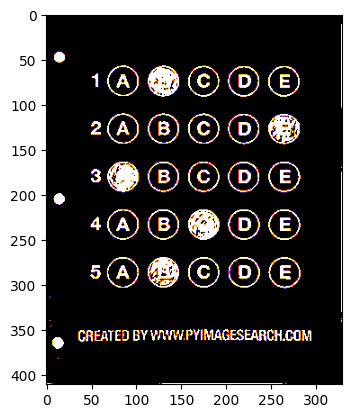

In [159]:
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh, cmap=plt.cm.CMRmap)


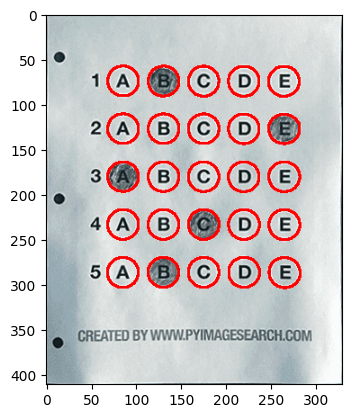

In [160]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
question_cnts = []

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    aspect_ratio = w / float(h)
    
    # filter bubble choices, the bubble size is around 20 pixels
    if w >= 20 and h >= 20 and aspect_ratio >= 0.9 and aspect_ratio <= 1.1:
        question_cnts.append(c)
 
img = paper.copy()   
cv2.drawContours(img, question_cnts, -1, (255,0,0),2)
plt.imshow(img)

loop over data format: [ 0  5 10 15 20]
question: 0
288 0
846 1
question: 1
287 0
328 1
740 4
question: 2
821 0
question: 3
292 0
325 1
825 2
question: 4
285 0
761 1


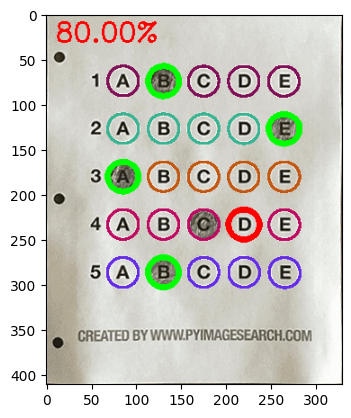

In [161]:
from random import randint


question_cnts = contours.sort_contours(question_cnts, method='top-to-bottom')[0]
correct = 0

top_bottom_group = paper.copy()
bubbled_list = []
print('loop over data format:',np.arange(0, len(question_cnts), 5))
for q, i in enumerate(np.arange(0, len(question_cnts), 5)):
    cnts = contours.sort_contours(question_cnts[i:i+5])[0]
    cv2.drawContours(top_bottom_group, cnts, -1, (randint(0, 255), randint(0, 255), randint(0, 255)), thickness=2)
    bubbled = None
    
    print('question:', q)
    for j, c in enumerate(cnts):
        mask = np.zeros(thresh.shape, dtype='uint8')
        cv2.drawContours(mask, [c], -1, 255, -1)

        # get highlighted choices, it returns 0 and 1
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        
        # plt.figure()
        # plt.imshow(mask, cmap=plt.cm.CMRmap)
        
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j,  c)
            print(bubbled[0], bubbled[1])

    bubbled_list.append(bubbled)
    
	# initialize the contour color and the index of the
	# *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]
    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
    cv2.drawContours(top_bottom_group, [cnts[k]], -1, color, 5)

score = (correct / 5) * 100
cv2.putText(top_bottom_group, '{:.2f}%'.format(score), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
plt.imshow(cv2.cvtColor(top_bottom_group, cv2.COLOR_BGR2RGB))
    

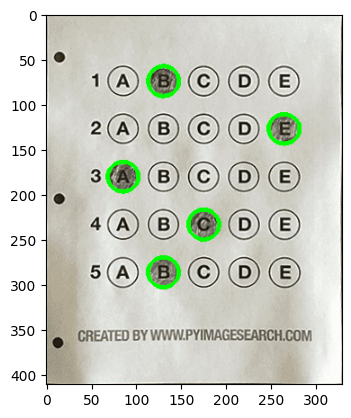

In [162]:
# highlight selected choices
img = paper.copy()
for c in  bubbled_list:
    cv2.drawContours(img, [c[2]], -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))